In [1]:
#!pip install wandb
import numpy as np
import pandas as pd
import wandb
import random
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import torch.nn.functional as F
from tqdm import tqdm
wandb.login()
import csv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
def read_and_split_data(train_file, test_file, val_file):
    # Read data
    train_data = pd.read_csv(train_file, header=None)
    test_data = pd.read_csv(test_file, header=None)
    val_data = pd.read_csv(val_file, header=None)

    # Split into English and Marathi words
    english_train = train_data.iloc[:, 0]
    marathi_train = train_data.iloc[:, 1]

    english_test = test_data.iloc[:, 0]
    marathi_test = test_data.iloc[:, 1]

    english_val = val_data.iloc[:, 0]
    marathi_val = val_data.iloc[:, 1]

    return (english_train, marathi_train, english_test, marathi_test, english_val, marathi_val)



In [3]:
# File paths
lang="mar"
train_file = f"/kaggle/input/aksharantar-sampled/aksharantar_sampled/{lang}/{lang}_train.csv"
test_file = f"/kaggle/input/aksharantar-sampled/aksharantar_sampled/{lang}/{lang}_test.csv"
val_file = f"/kaggle/input/aksharantar-sampled/aksharantar_sampled/{lang}/{lang}_valid.csv"

# Call the function
english_train, marathi_train, english_test, marathi_test, english_val, marathi_val = read_and_split_data(train_file, test_file, val_file)

In [4]:
def create_char_list(words):
    char_set = set(char for word in words for char in word)
    char_list = sorted(char_set)
    max_length_word = max(len(word) for word in words)
    return char_list, max_length_word


def find_max_length(word_list):
    max_length = -1
    for word in word_list:
        max_length = max(max_length, len(word))
    return max_length

# Create character lists and find maximum word lengths
english_chars, english_max_len = create_char_list(english_train)
marathi_chars, marathi_max_len = create_char_list(marathi_train)

# Find maximum word lengths from validation and test data
english_max_len = max(find_max_length(english_val), find_max_length(english_test), english_max_len)
marathi_max_len = max(find_max_length(marathi_val), find_max_length(marathi_test), marathi_max_len)

In [5]:
def word_to_vector(word, lang):
    max_len = -1
    if lang == "english":
        max_len = english_max_len
    else:
        max_len = marathi_max_len

    vector = [0] * (max_len + 2)  # Initialize vector with max length + 2 (for special tokens)
    vector[0] = len(english_chars) + 1 if lang == "english" else len(marathi_chars) + 1
    count=1
    if(lang == "english"):
        for char in word:
            for i in range(len(english_chars)):
                if(english_chars[i] == char):
                    vector[count]=i+1
                    count+=1
    else :
        for char in word:
            for i in range(len(marathi_chars)):
                if(marathi_chars[i] == char):
                    vector[count]=i+1
                    count+=1

    return vector


In [6]:
def indices_to_words(indices, language):
    words = []
    char_list = english_chars if language == "english" else marathi_chars
    for idx in range(len(indices)):
        if idx == 0:
            continue
        if indices[idx]==0:
            break
        char = char_list[indices[idx] - 1]  # Adjust for zero-indexing
        words.append(char)
    return ''.join(words)

In [7]:
# creating matrix of representation
def word_matrix(words, language):
    matrix = []
    for word in words:
        matrix.append(word_to_vector(word, language))
    return torch.tensor(matrix)

In [8]:
def prepare_word_matrices(train_data, val_data, test_data, language):
    train_matrix = word_matrix(train_data, language)
    val_matrix = word_matrix(val_data, language)
    test_matrix = word_matrix(test_data, language)
    return train_matrix, val_matrix, test_matrix

In [9]:
english_matrix, english_matrix_val, english_matrix_test = prepare_word_matrices(english_train, english_val, english_test, "english")
marathi_matrix, marathi_matrix_val, marathi_matrix_test = prepare_word_matrices(marathi_train, marathi_val, marathi_test, "marathi")

In [10]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, batch_size, dropout_prob, bidirectional, cell_type):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.dropout = nn.Dropout(dropout_prob)
        self.biderectional = bidirectional
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.cell_type = cell_type

        rnn_class = nn.RNN if cell_type == "RNN" else (nn.LSTM if cell_type == "LSTM" else nn.GRU)
        self.rnn = rnn_class(embedding_dim, hidden_size, num_layers, dropout=dropout_prob, bidirectional=bidirectional)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        if self.cell_type == "LSTM":
            output, (hidden, cell) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded)

        return (output, hidden, cell) if self.cell_type == "LSTM" else (output, hidden)

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, dec_layers, p, cell_type, attention=False, bidirectional=False):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dec_layers = dec_layers
        self.dropout = nn.Dropout(p)
        self.cell_type = cell_type
        self.attention = attention
        self.bidirectional = bidirectional
        self.max_length = len(english_matrix[0])
        self.attn_weights=0

        self.embedding = nn.Embedding(input_size, embedding_size)
        rnn_input_size = hidden_size if attention else embedding_size
        rnn_class = nn.RNN if cell_type == "RNN" else (nn.LSTM if cell_type == "LSTM" else nn.GRU)
        self.rnn = rnn_class(rnn_input_size, hidden_size, dec_layers, dropout=p)
        self.fc = nn.Linear(hidden_size, output_size)

        if attention:
            self.attn = nn.Linear(hidden_size + embedding_size, self.max_length)
            self.attn_combine = nn.Linear(hidden_size * 2 + embedding_size, hidden_size) if bidirectional else nn.Linear(hidden_size + embedding_size, hidden_size)

    def forward(self, x, output, hidden, cell=None):
      x = x.unsqueeze(0)
      embedded = self.embedding(x)
      embedded = self.dropout(embedded)

      if self.attention:
          attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
          self.attn_weights = attn_weights  # Store attention weights
          attn_applied = torch.bmm(attn_weights.unsqueeze(1), output.permute(1, 0, 2)).squeeze(1)
          op = torch.cat((embedded[0], attn_applied), 1)
          op = self.attn_combine(op).unsqueeze(0)
          op = F.relu(op)
      else:
          op = embedded

      if self.cell_type == "LSTM":
          outputs, (hidden, cell) = self.rnn(op, (hidden, cell))
      else:
          outputs, hidden = self.rnn(op, hidden)

      predictions, hidden, cell = self.generate_predictions(outputs, hidden, cell)

      return predictions, hidden, cell


    def generate_predictions(self, rnn_outputs, rnn_hidden, rnn_cell=None):
        output_predictions = self.fc(rnn_outputs)
        output_predictions = output_predictions.squeeze(0)

        return (output_predictions, rnn_hidden, rnn_cell) if self.cell_type == "LSTM" else (output_predictions, rnn_hidden ,rnn_cell)


    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [12]:
class Seq2SeqModel(nn.Module):
    def __init__(self, output_size, cell_type, bidirectional, enc_layers, dec_layers, encoder, decoder,attention):
        super(Seq2SeqModel, self).__init__()
        self.output_size = output_size
        self.cell_type = cell_type
        self.bidirectional = bidirectional
        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.encoder = encoder
        self.attention=attention
        self.decoder = decoder

    def forward(self, source, target , teacher_force_ratio=0.5):
        target_len = target.shape[0]
        batch_size = source.shape[1]

        outputs = torch.zeros(target_len, batch_size, self.output_size).to(source.device)

        encoder_output, hidden, cell = self.encode_sequence(source)
        hidden, cell = self.prepare_decoder_states(hidden, cell)
        outputs,attentions = self.decode_sequence(target, encoder_output, hidden, cell, teacher_force_ratio)

        return outputs,attentions

    def encode_sequence(self, source):
        if self.cell_type == "LSTM":
            encoder_output, hidden, cell = self.encoder(source)
            return encoder_output, hidden, cell
        else:
            encoder_output, hidden = self.encoder(source)
            return encoder_output, hidden, None

    def prepare_decoder_states(self, hidden, cell):
        if self.bidirectional or self.enc_layers != self.dec_layers:
          hidden = hidden[self.enc_layers - 1] + hidden[self.enc_layers - 1]
          hidden = hidden.repeat(self.dec_layers,1,1)
          if(self.cell_type == "LSTM"):
              cell = cell[self.enc_layers - 1] + cell[self.enc_layers - 1]
              cell = cell.repeat(self.dec_layers,1,1)
        return hidden, cell


    def decode_sequence(self, tgt, enc_out, hid, cell, teacher_force_ratio):
      batch_size = tgt.shape[1]
      target_len = tgt.shape[0]
      outputs = torch.zeros(target_len, batch_size, self.output_size).to(enc_out.device)
      attentions = []

      timestep = 1
      current_token = tgt[0]

      while timestep < target_len:
          if self.cell_type == "LSTM":
              output, hid, cell = self.decoder(current_token, enc_out, hid, cell)
          else:
              output, hid, cell = self.decoder(current_token, enc_out, hid)
          outputs[timestep] = output

          if(self.attention==True):
            attentions.append(self.decoder.attn_weights.detach().cpu().numpy())

          if random.random() < teacher_force_ratio:
              current_token = tgt[timestep] if timestep < target_len - 1 else output.argmax(1)
          else:
              current_token = output.argmax(1)

          timestep += 1

      attentions = np.array(attentions)
      return outputs, attentions


In [13]:
def calculate_accuracy_test(model, input_data, target_data, batch_size):
    correct_count = 0
    total_samples = len(input_data)
    predicted_words=[]
    attention_list=[np.random.rand(10, 10)]
    for idx in range(0, total_samples, batch_size):
        input_batch = input_data[idx:idx + batch_size].to(device)
        target_batch = target_data[idx:idx + batch_size].to(device)

        output,attentions = model(input_batch.T, target_batch.T, teacher_force_ratio=0)
        if idx==0:
          attention_list[0]=attentions
        predicted_tokens = torch.argmax(F.softmax(output, dim=2), dim=2).T
        
        for tokens in predicted_tokens:
            predicted_word = indices_to_words(tokens, "marathi")
            predicted_words.append(predicted_word)
            
        correct_count += torch.all(predicted_tokens[:, 1:] == target_batch[:, 1:], dim=1).sum().item()
        
    accuracy = correct_count * 100 / total_samples
    return accuracy,predicted_words,attention_list


In [14]:
def calculate_accuracy(model, input_data, target_data, batch_size):
    correct_count = 0
    total_samples = len(input_data)
    for idx in range(0, total_samples, batch_size):
        input_batch = input_data[idx:idx + batch_size].to(device)
        target_batch = target_data[idx:idx + batch_size].to(device)

        output,attentions = model(input_batch.T, target_batch.T, teacher_force_ratio=0)
        predicted_tokens = torch.argmax(F.softmax(output, dim=2), dim=2).T

        correct_count += torch.all(predicted_tokens[:, 1:] == target_batch[:, 1:], dim=1).sum().item()

    accuracy = correct_count * 100 / total_samples
    return accuracy


In [15]:

def plot_attention_heatmap_grid(actual_words, predicted_words, attention_weights_list):
    num_plots = min(len(actual_words), 9)  # Limit to 9 plots for a 3x3 grid
    num_rows = 3
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

    # Load custom font
    prop = fm.FontProperties(fname="/kaggle/input/marathi-text/Mukta-Regular.ttf")

    for i in range(num_plots):
        row = i // num_cols
        col = i % num_cols

        actual_word = actual_words[i]
        predicted_word = predicted_words[i]
        attention_weights = attention_weights_list[i]
        print(actual_word,predicted_word)
        actual_len = len(actual_word)
        predicted_len = len(predicted_word)
        heatmap_data = np.zeros((predicted_len, actual_len))

        for j in range(predicted_len):
            for k in range(actual_len):
                heatmap_data[j][k] = attention_weights[j][k]

        # Plot heatmap
        im = axes[row, col].imshow(heatmap_data, cmap='viridis', aspect='auto')
        cbar = fig.colorbar(im, ax=axes[row, col])  # Add color bar

        # Set x and y tick labels with the custom font
        axes[row, col].set_xticks(np.arange(len(actual_word)))
        axes[row, col].set_yticks(np.arange(len(predicted_word)))
        axes[row, col].set_xticklabels(list(actual_word))
        axes[row, col].set_yticklabels(list(predicted_word), fontproperties=prop)
        
        # Set title and labels
        axes[row, col].set_title(f'Heatmap-{i+1}', fontproperties=prop, fontsize=22)
        axes[row, col].tick_params(axis='x', labelsize=22)
        axes[row, col].tick_params(axis='y', labelsize=22)

        # Adjust color bar font size
        cbar.ax.tick_params(labelsize=18)

    # Hide empty subplots if fewer than 9 examples
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    # Log to WandB
    wandb.log({"Attention_Heatmaps": plt})
    plt.show()



In [16]:
def write_to_csv(actual_english, actual_marathi, predicted_marathi, filename):
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Actual English', 'Actual Marathi', 'Predicted Marathi'])
        for eng, mar_actual, mar_pred in zip(actual_english, actual_marathi, predicted_marathi):
            writer.writerow([eng, mar_actual, mar_pred])


In [17]:
def train_model(epochs, learning_rate, cell_type, bidirectional, enc_layers, dec_layers, batch_size, embedding_dim, hidden_size, enc_dropout, dec_dropout,attention):
    pad_idx = len(marathi_chars) + 1
    plot_heatmap=True
    input_size_encoder = len(english_chars)
    input_size_decoder = len(marathi_chars)
    output_size = len(marathi_chars)
    input_size_encoder+=2
    input_size_decoder+=2
    output_size+=2

    encoder = Encoder(input_size_encoder, embedding_dim, hidden_size, enc_layers,batch_size, enc_dropout,bidirectional, cell_type).to(device)
    decoder= Decoder(input_size_decoder,embedding_dim,hidden_size,output_size,dec_layers,dec_dropout, cell_type,attention,bidirectional).to(device)

    model = Seq2SeqModel(output_size, cell_type, bidirectional, enc_layers, dec_layers ,encoder, decoder,attention).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    for epoch in range(epochs):
        print("Epoch: ", epoch+1)

        model.train()
        total_loss = 0
        val_loss = 0
        step = 0
        total_batches = len(english_matrix) // batch_size

        for batch_idx in tqdm(range(total_batches)):
            start_idx = batch_size * batch_idx
            end_idx = batch_size * (batch_idx + 1)

            inp_data = english_matrix[start_idx:end_idx].to(device)
            target = marathi_matrix[start_idx:end_idx].to(device)
            target = target.T

            optimizer.zero_grad()
            output, attentions = model(inp_data.T, target)
            
            output = output[1:].reshape(-1, output.shape[2])
            target = target[1:].reshape(-1)

            loss = criterion(output, target)
            total_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            optimizer.step()

            step += 1

        with torch.no_grad():
            model.eval()
            val_batches = len(english_matrix_val) // batch_size
            for val_batch_idx in range(val_batches):
                val_start_idx = batch_size * val_batch_idx
                val_end_idx = batch_size * (val_batch_idx + 1)

                val_inp_data = english_matrix_val[val_start_idx:val_end_idx].to(device)
                val_target = marathi_matrix_val[val_start_idx:val_end_idx].to(device)
                val_target = val_target.T

                val_output,attentions = model(val_inp_data.T, val_target)
                val_output = val_output[1:].reshape(-1, val_output.shape[2])
                val_target = val_target[1:].reshape(-1)

                val_loss += criterion(val_output, val_target).item()

            val_loss /= val_batches
        training_accuracy = calculate_accuracy(model, english_matrix, marathi_matrix, batch_size)
        val_accuracy = calculate_accuracy(model, english_matrix_val, marathi_matrix_val, batch_size)
      
        wandb.log({
           "Epoch": epoch+1,
           "Loss": total_loss / step,
           "Accuracy": training_accuracy,
           "Val_Accuracy": val_accuracy,
           "Val_Loss": val_loss
        })
        print(f"Loss: {total_loss/step}\t Accuracy: {training_accuracy}\t Val_Accuracy: {val_accuracy}\t Val_Loss: {val_loss}")
    test_accuracy,predicted_words,attention_list=calculate_accuracy_test(model, english_matrix_test, marathi_matrix_test, batch_size)
    #write_to_csv(english_test, marathi_test, predicted_words, '/kaggle/working/predictions_vanilla.csv')
    print("Test_Accuracy",test_accuracy)
    #wandb.log({'Test_Accuracy_Without_Attention':test_accuracy})
    if(plot_heatmap==True):
      plot_attention_heatmap_grid(english_test[:10], marathi_test[:10], attention_list[0][:10])

In [18]:
# Define the sweep configuration
sweep_config = {
    "method": "bayes",
    'metric': {
        'name': 'Val_Accuracy',
        'goal': 'maximize'
    },
    "parameters": {
        "epochs": {"values": [ 10, 15 , 20]},  
        "learning_rate": {"values": [1e-3, 1e-4]},
        "cell_type": {"values": ["RNN","LSTM", "GRU"]},
        "bidirectional": {"values": [True, False]},
        "enc_layers": {"values": [1, 2, 3, 4 ,5]},
        "dec_layers": {"values": [1, 2, 3, 4 ,5]},
        "batch_size": {"values": [128, 256, 512]},
        "embedding_dim": {"values": [256, 384, 512]},
        "hidden_size": {"values": [256, 384, 512]},
        "enc_dropout": {"values": [0, 0.1, 0.2]},
        "dec_dropout": {"values": [0, 0.1, 0.2]},
        "attention": {"values": [False]}
    }
}

Create sweep with ID: ihrvjaq2
Sweep URL: https://wandb.ai/cs23m063/deep_learn_assignment_3/sweeps/ihrvjaq2


wandb: Agent Starting Run: 1aemygh7 with config:
wandb: 	attention: True
wandb: 	batch_size: 256
wandb: 	bidirectional: True
wandb: 	cell_type: LSTM
wandb: 	dec_dropout: 0.1
wandb: 	dec_layers: 1
wandb: 	embedding_dim: 512
wandb: 	enc_dropout: 0.2
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_size: 384
wandb: 	learning_rate: 0.001
wandb: Currently logged in as: cs23m063. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch:  1


100%|██████████| 200/200 [00:16<00:00, 11.79it/s]


Loss: 1.1723946386575699	 Accuracy: 14.416015625	 Val_Accuracy: 14.599609375	 Val_Loss: 0.44641731679439545
Epoch:  2


100%|██████████| 200/200 [00:15<00:00, 12.69it/s]


Loss: 0.40258435741066934	 Accuracy: 30.888671875	 Val_Accuracy: 29.0771484375	 Val_Loss: 0.2947191521525383
Epoch:  3


100%|██████████| 200/200 [00:16<00:00, 12.47it/s]


Loss: 0.28613515973091125	 Accuracy: 38.662109375	 Val_Accuracy: 33.69140625	 Val_Loss: 0.2460602717474103
Epoch:  4


100%|██████████| 200/200 [00:16<00:00, 12.32it/s]


Loss: 0.23685578294098378	 Accuracy: 44.662109375	 Val_Accuracy: 36.2548828125	 Val_Loss: 0.22636467590928078
Epoch:  5


100%|██████████| 200/200 [00:16<00:00, 12.24it/s]


Loss: 0.20837192937731744	 Accuracy: 49.0546875	 Val_Accuracy: 39.0380859375	 Val_Loss: 0.23964918963611126
Epoch:  6


100%|██████████| 200/200 [00:16<00:00, 11.97it/s]


Loss: 0.18619723487645387	 Accuracy: 53.22265625	 Val_Accuracy: 40.234375	 Val_Loss: 0.2255896208807826
Epoch:  7


100%|██████████| 200/200 [00:16<00:00, 12.19it/s]


Loss: 0.16281626399606466	 Accuracy: 56.578125	 Val_Accuracy: 42.041015625	 Val_Loss: 0.2303009945899248
Epoch:  8


100%|██████████| 200/200 [00:16<00:00, 12.29it/s]


Loss: 0.1478970228880644	 Accuracy: 57.89453125	 Val_Accuracy: 41.50390625	 Val_Loss: 0.21873454935848713
Epoch:  9


100%|██████████| 200/200 [00:16<00:00, 12.12it/s]


Loss: 0.13300590563565493	 Accuracy: 62.6328125	 Val_Accuracy: 44.0185546875	 Val_Loss: 0.20537173748016357
Epoch:  10


100%|██████████| 200/200 [00:16<00:00, 12.15it/s]


Loss: 0.13365039557218553	 Accuracy: 64.27734375	 Val_Accuracy: 44.8974609375	 Val_Loss: 0.22011911869049072
Epoch:  11


100%|██████████| 200/200 [00:16<00:00, 12.21it/s]


Loss: 0.11644492402672768	 Accuracy: 64.85546875	 Val_Accuracy: 45.2392578125	 Val_Loss: 0.2214966844767332
Epoch:  12


100%|██████████| 200/200 [00:16<00:00, 12.20it/s]


Loss: 0.10746729731559754	 Accuracy: 66.935546875	 Val_Accuracy: 45.7275390625	 Val_Loss: 0.21931479964405298
Epoch:  13


100%|██████████| 200/200 [00:16<00:00, 12.23it/s]


Loss: 0.09835392516106367	 Accuracy: 69.875	 Val_Accuracy: 44.9462890625	 Val_Loss: 0.2005409337580204
Epoch:  14


100%|██████████| 200/200 [00:16<00:00, 12.18it/s]


Loss: 0.09252386033535004	 Accuracy: 73.826171875	 Val_Accuracy: 45.849609375	 Val_Loss: 0.21799489576369524
Epoch:  15


100%|██████████| 200/200 [00:16<00:00, 12.23it/s]


Loss: 0.081315224673599	 Accuracy: 75.685546875	 Val_Accuracy: 46.6064453125	 Val_Loss: 0.21751512493938208
Test_Accuracy 40.966796875
heetler हिटलर
kshama क्षमा
jinkta जिंकता
kaushik कौशिक
jaadoogar जादूगर
chaalavanyaachaa चालवण्याचा
samaajkaaryaat समाजकार्यात
thandine थंडीने
maalmtaadharkaanmdhey मालमत्ताधारकांमध्ये


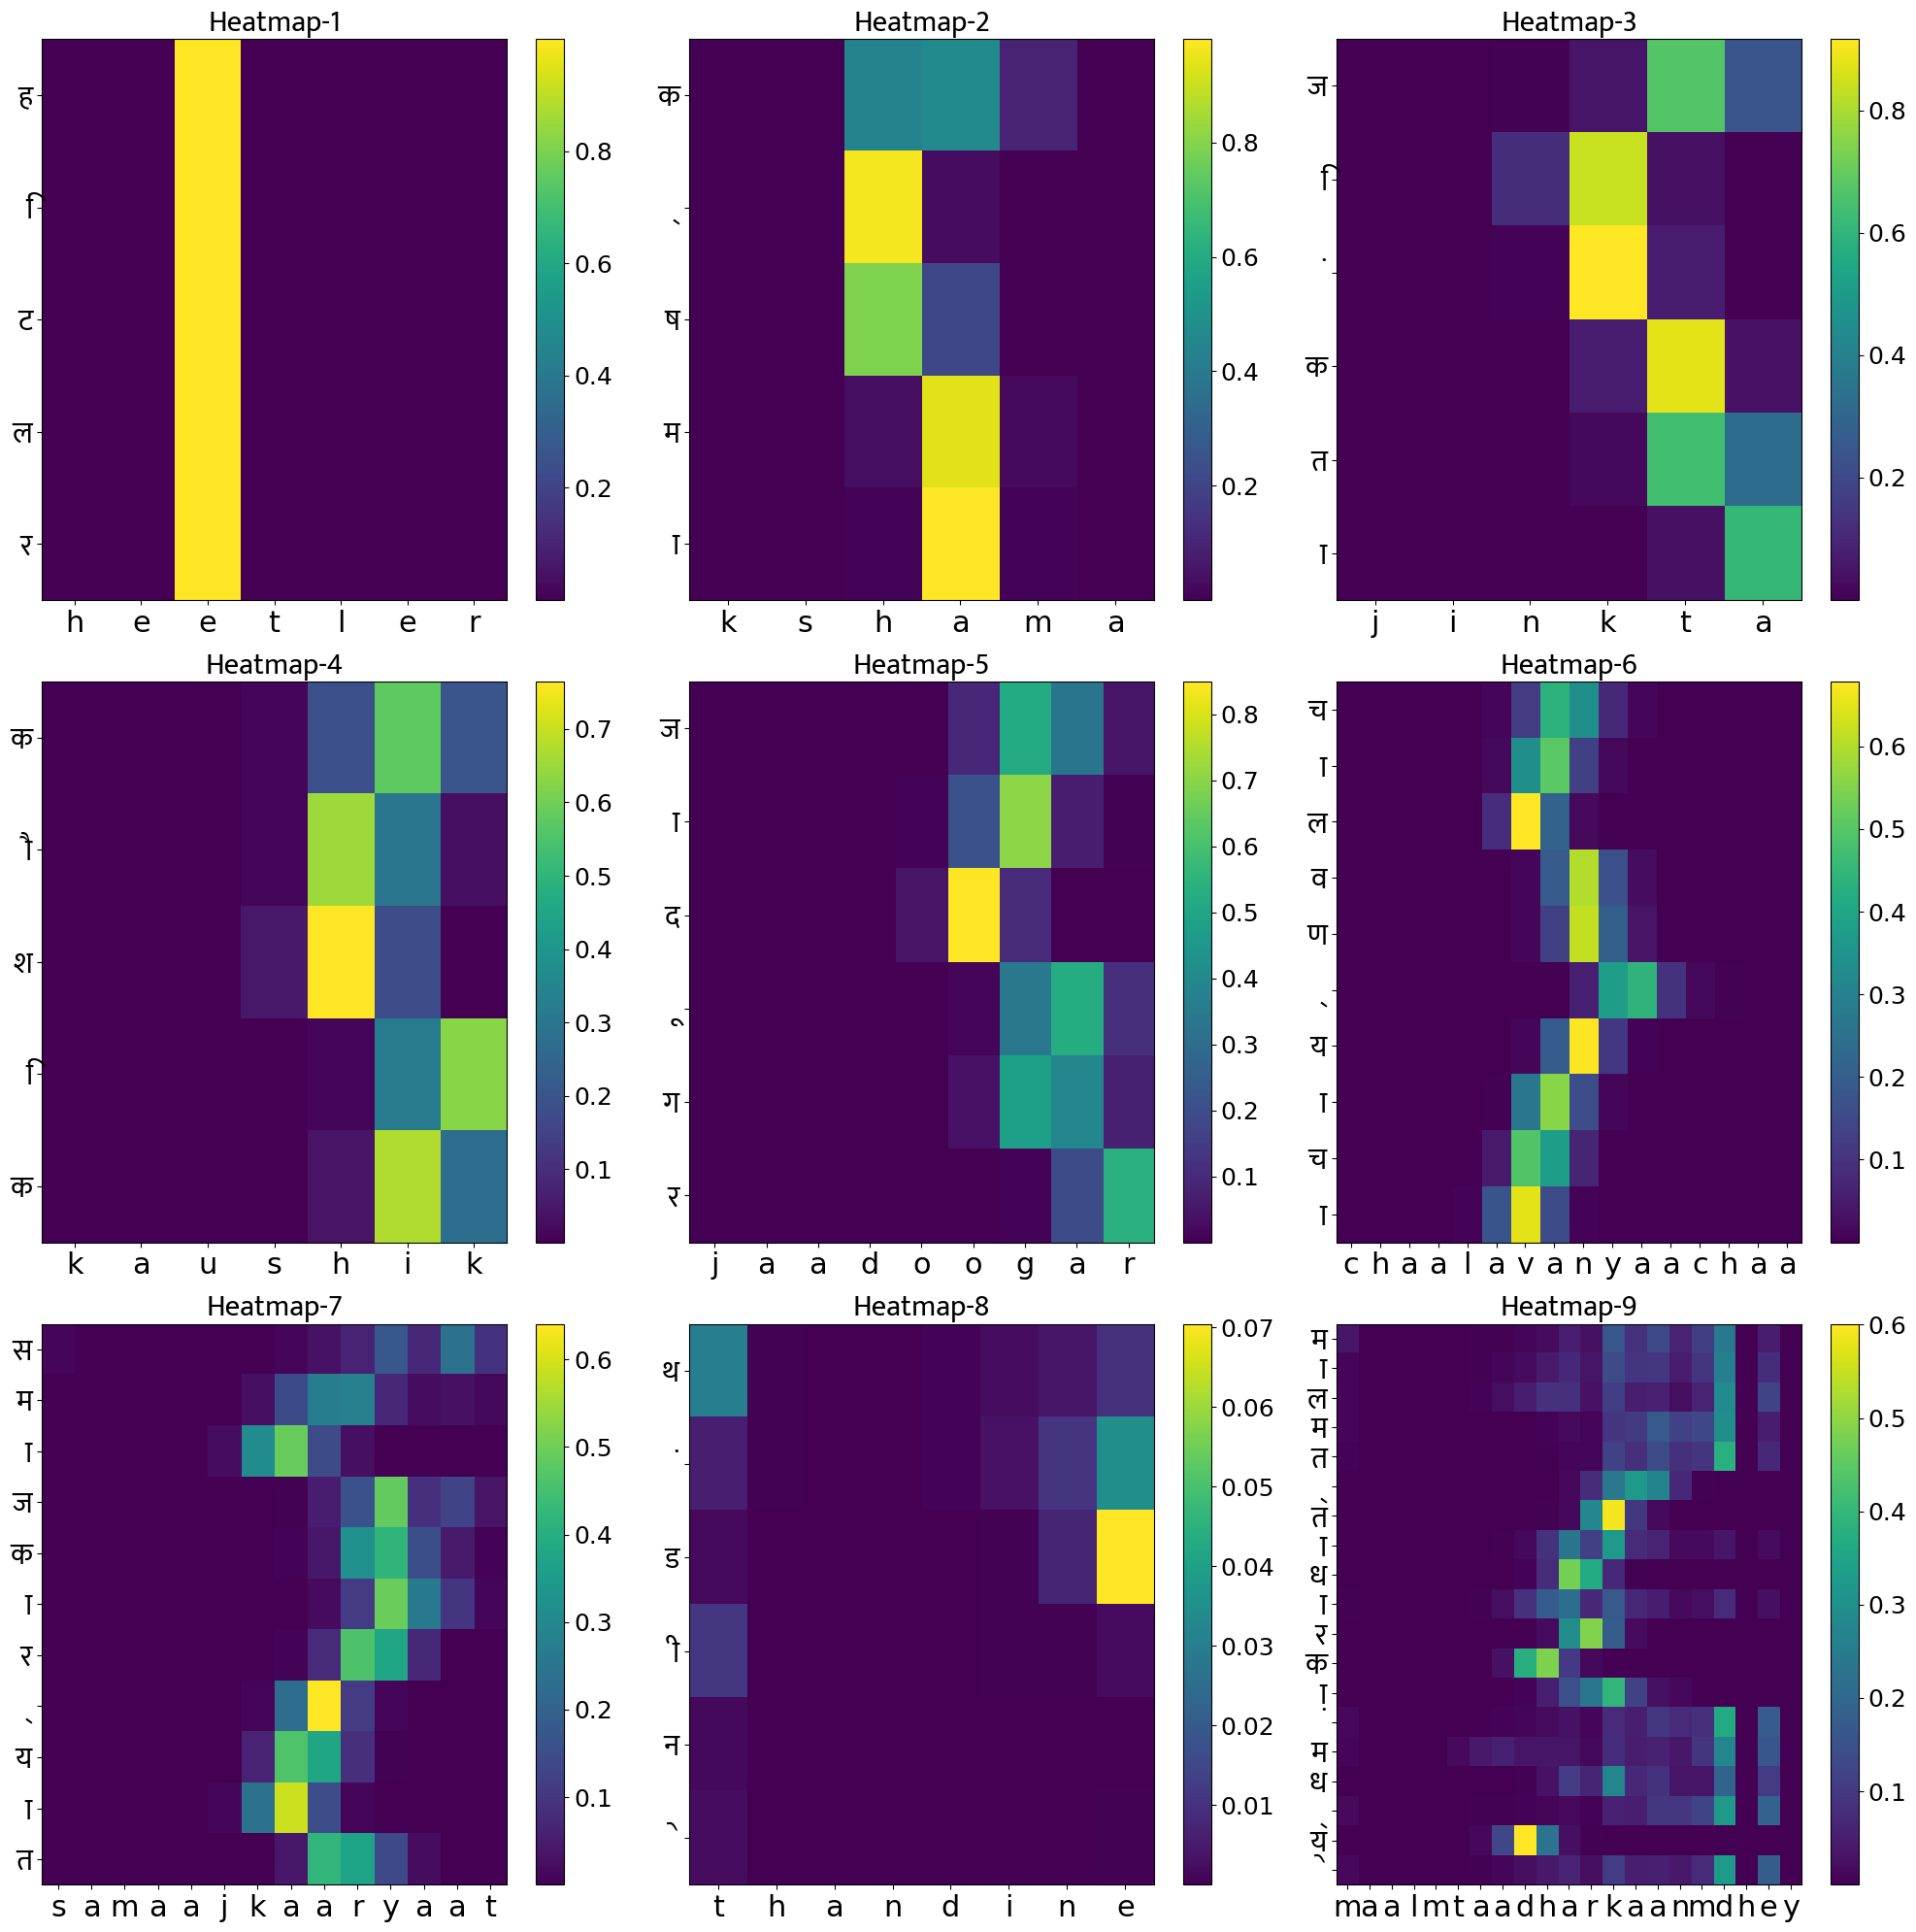

Accuracy,▁▃▄▄▅▅▆▆▇▇▇▇▇██
Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Val_Accuracy,▁▄▅▆▆▇▇▇▇██████
Val_Loss,█▄▂▂▂▂▂▂▁▂▂▂▁▁▁
Accuracy,75.68555
Epoch,15
Loss,0.08132
Val_Accuracy,46.60645
Val_Loss,0.21752


In [19]:
def main():
    # Initialize wandb
    wandb.init()
    config = wandb.config
    wandb.run.name = "_".join([f"{param}:{value}" for param, value in config.items()])
    train_model(**config)

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="deep_learn_assignment_3",entity="cs23m063")

# Run the sweep
wandb.agent(sweep_id, function=main,count=1)